## Introduction: BERT using PyTorch
BERT (Bidirectional Encoder Representations from Transformers) is a state-of-the-art NLP model developed by Google that understands context in a sentence by leveraging bidirectional attention. It has revolutionized NLP tasks like text classification, question answering, and named entity recognition.

In this notebook, we will explore how to implement BERT using PyTorch, fine-tune it on a dataset, and evaluate its performance. We will leverage Hugging Face's Transformers library to efficiently train and deploy the model. Let's dive into BERT’s power and applications!

## Importing Libraries and Setting the Configurations

In [1]:
# Preprocessing base libraries
import numpy as np
import pandas as pd

# For visualization
import seaborn as sns
from matplotlib import rc
from pylab import rcParams
import matplotlib.pyplot as plt

# For preprocessing the text data
import re
from textwrap import wrap
from textblob import TextBlob
from collections import Counter
from string import punctuation
from nltk import word_tokenize, ngrams

# Model evaluation and processing libraries
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# PyTorch required libraries
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Transformer libraries 
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import time
import warnings
from tqdm import tqdm
from collections import defaultdict
warnings.filterwarnings('ignore')

# Setting the Plotting Defaults
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Using GPU if available otherwise CPU Cores 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

# Punctuations
punctuation = punctuation + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

cuda:0


In [2]:
# Importing the dataset
df = pd.read_csv('/kaggle/input/quora-insincere-questions-classification/train.csv')
print ("The Shape of the dataset : ", df.shape)
df.head()

The Shape of the dataset :  (1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [3]:
df['target'].value_counts() # The Target is highly skewed as we can see

target
0    1225312
1      80810
Name: count, dtype: int64

In [4]:
# Checing for the null values
df.isnull().sum(axis = 0)

qid              0
question_text    0
target           0
dtype: int64

## Exploratory Data Analysis

In [5]:
# Changing the target values for the EDA for now
df['target'] = df['target'].map({1 : 'Insincere', 0 : 'Sincere'})

### Distribution of Insincere and Sincere Questions

The percentages of Sincere and Insincere Questions are :  [93.81298224821265, 6.187017751787352]


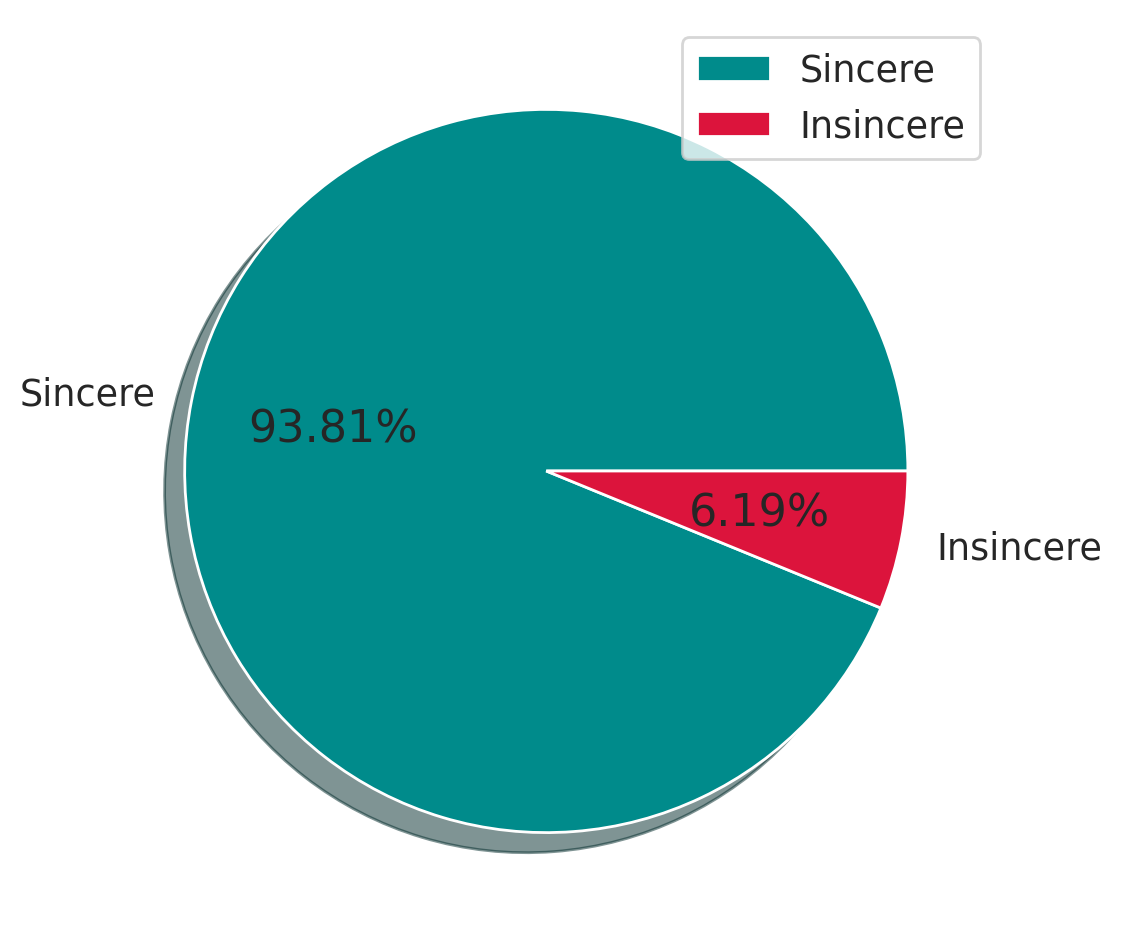

In [6]:
# Distribution of the Insincere and Sincere Questions
plt.rcParams['figure.figsize'] = [10, 5]

# Creating the labels for the piechart
types = df['target'].value_counts()
labels = list(types.index)
aggregate = list(types.values)
percentage = [(x*100)/sum(aggregate) for x in aggregate]
print ("The percentages of Sincere and Insincere Questions are : ", percentage)

# Plotting the Piechart to see the percentage distribution of the questions
plt.rcParams.update({'font.size': 16})
explode = (0, 0.1)
plt.pie(aggregate, labels = labels, autopct='%1.2f%%', shadow=True, colors = ['darkcyan', 'crimson'])
plt.legend(labels, loc = 'best')
plt.tight_layout()
plt.show()

### Ngrams (Unigrams and Bigrams)

In [7]:
# Copying the dataset for the ngrams so that it won't effect the further processes
df_ = df.copy()
df_['question_text'] = df_['question_text'].str.replace(r'[^\w\d\s]',' ')

# Segregating the questions
df_insincere = " ".join(df_.loc[df_.target == 'Insincere', 'question_text'])
df_sincere = " ".join(df_.loc[df_.target == 'Sincere', 'question_text'])

# Tokenizing the Sentences
tokenized_insincere = word_tokenize(df_insincere)
tokenized_sincere = word_tokenize(df_sincere)

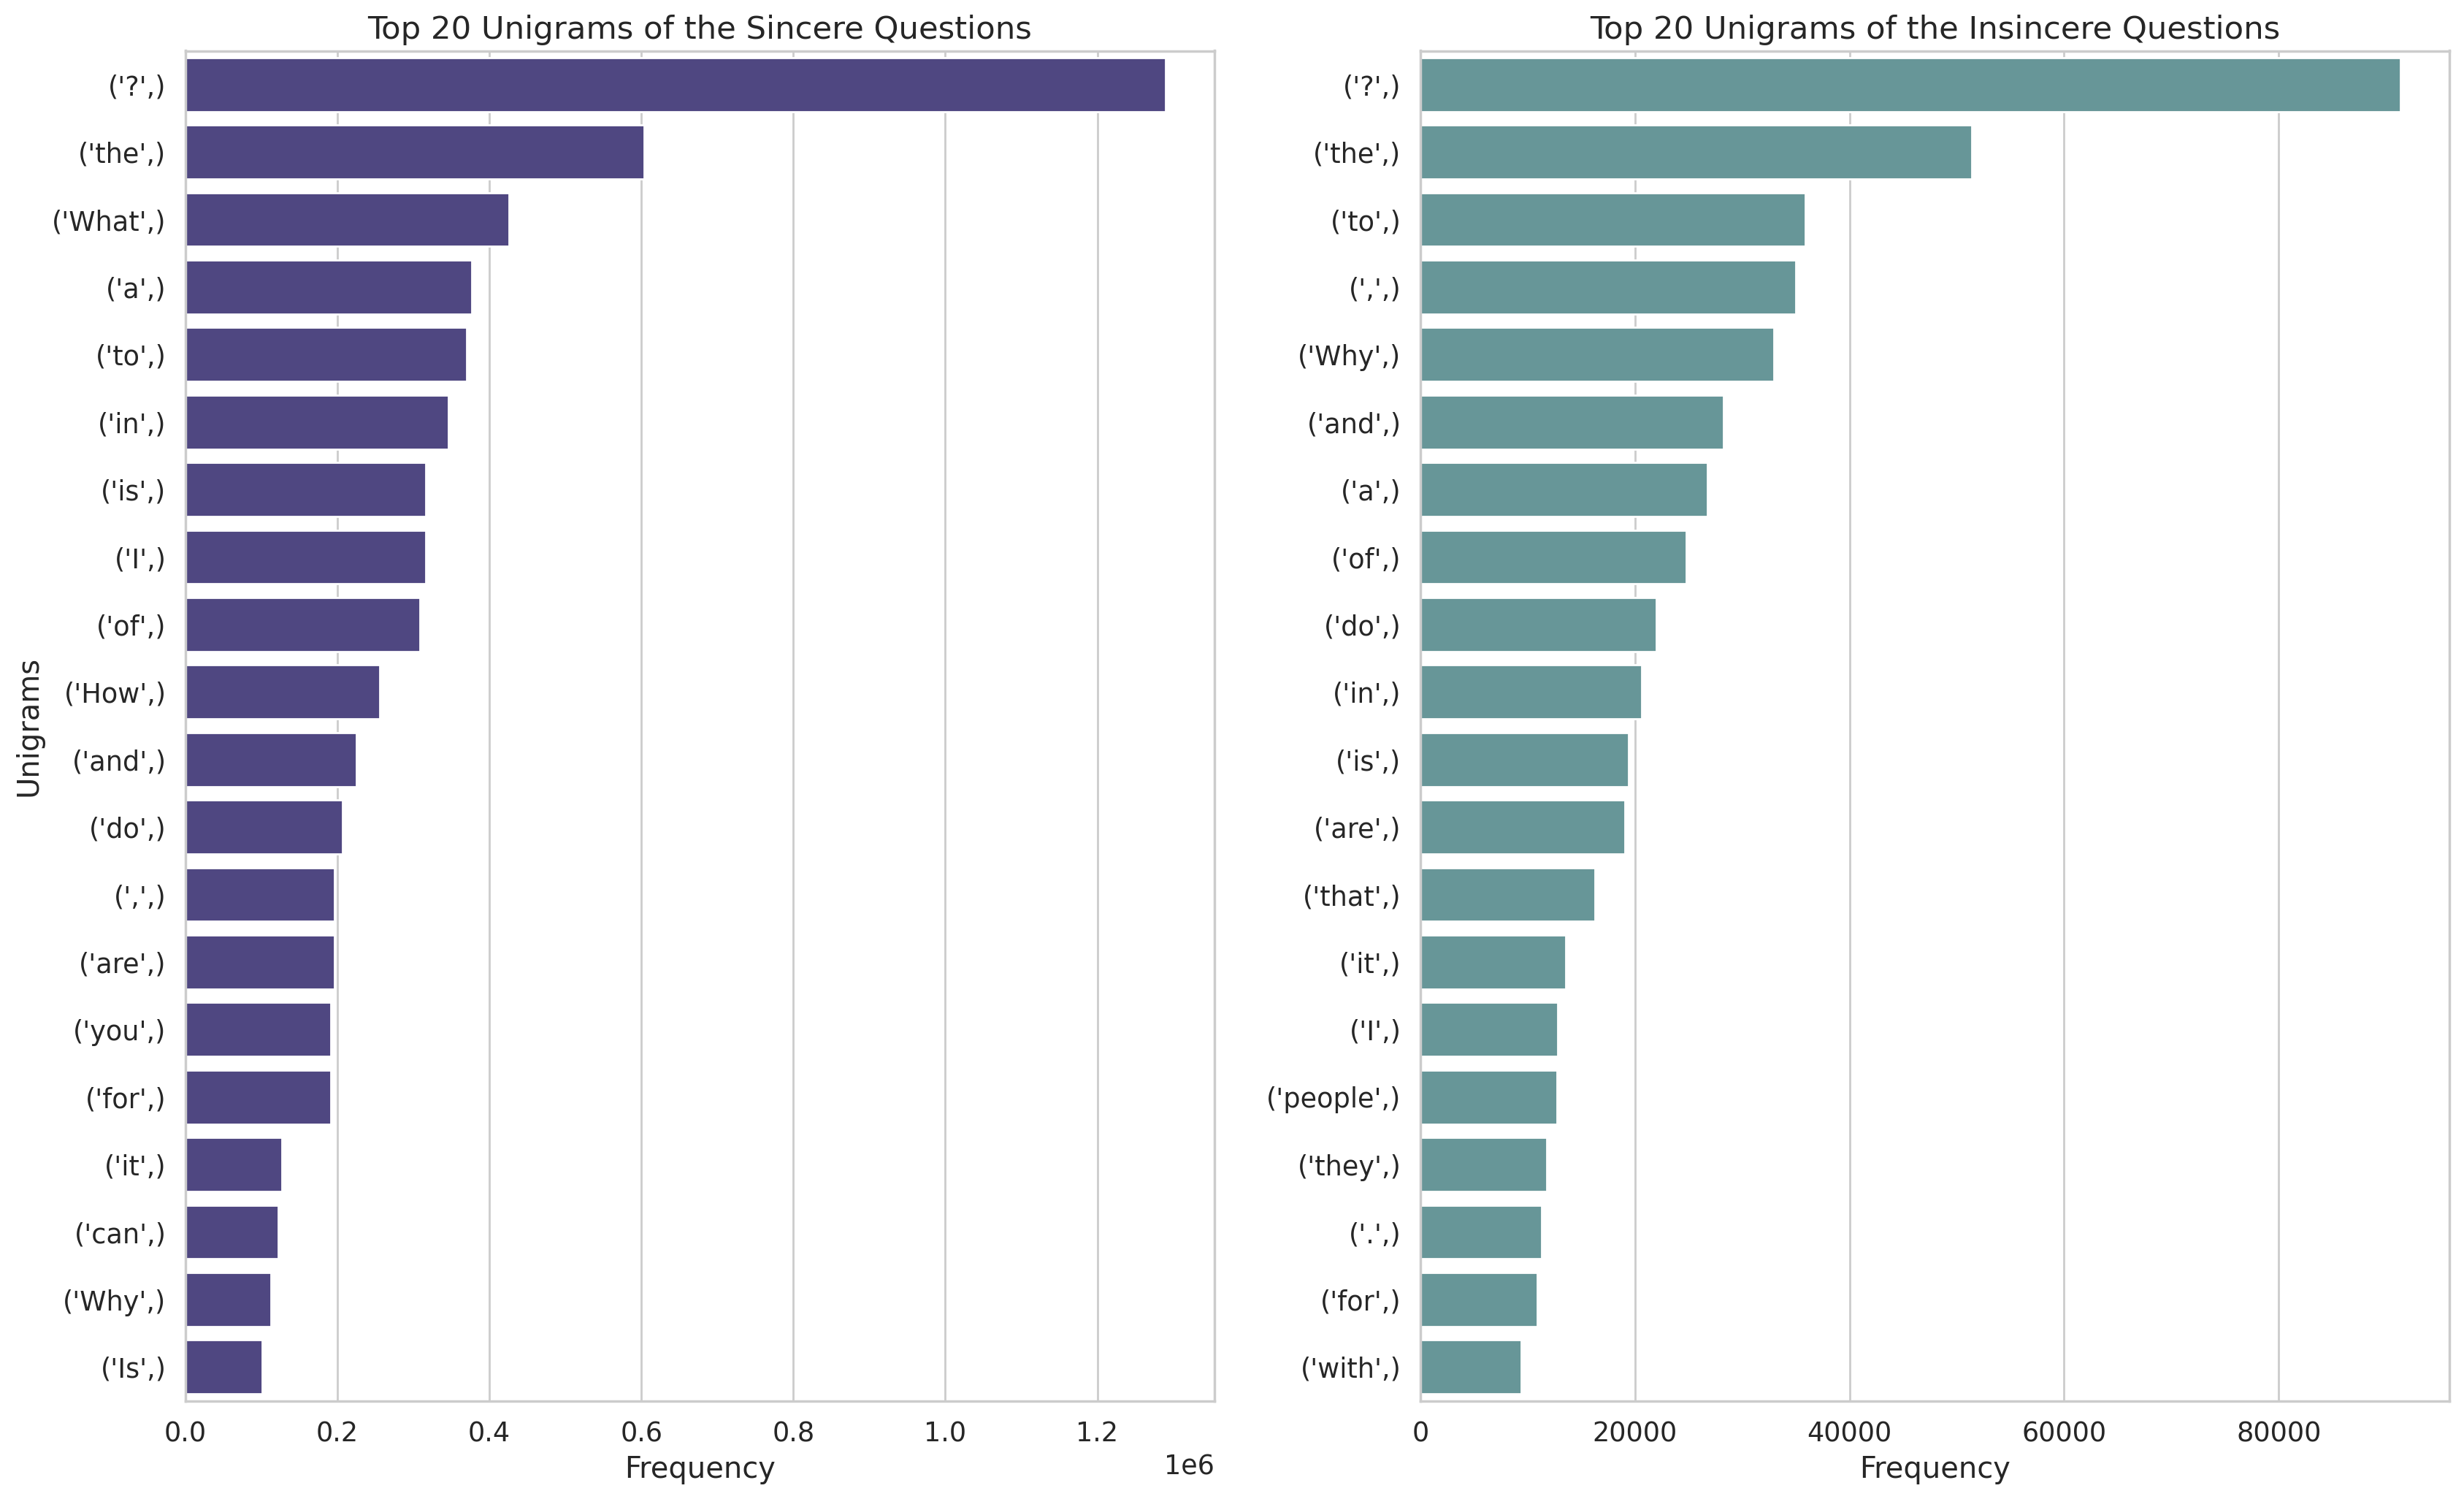

In [8]:
# Unigrams
unigram_insincere = ngrams(tokenized_insincere, 1)
unigram_sincere = ngrams(tokenized_sincere, 1)

# Making the Frequency chart for the Unigrams
frequency_insincere = Counter(unigram_insincere) 
frequency_sincere = Counter(unigram_sincere)

df_freq_insincere = pd.DataFrame(frequency_insincere.most_common(20))
df_freq_sincere = pd.DataFrame(frequency_sincere.most_common(20))

# Barplot that shows the top 20 Unigrams
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.3, style = 'darkgrid')

sns_sincere = sns.barplot(x = df_freq_sincere[1], y = df_freq_sincere[0], color = 'darkslateblue', ax = ax[0])
sns_insincere = sns.barplot(x = df_freq_insincere[1], y = df_freq_insincere[0], color = 'cadetblue', ax = ax[1])

# Setting axes
sns_sincere.set(title = "Top 20 Unigrams of the Sincere Questions", ylabel = "Unigrams", xlabel = "Frequency")
sns_insincere.set(title = "Top 20 Unigrams of the Insincere Questions", xlabel = "Frequency", ylabel = "");

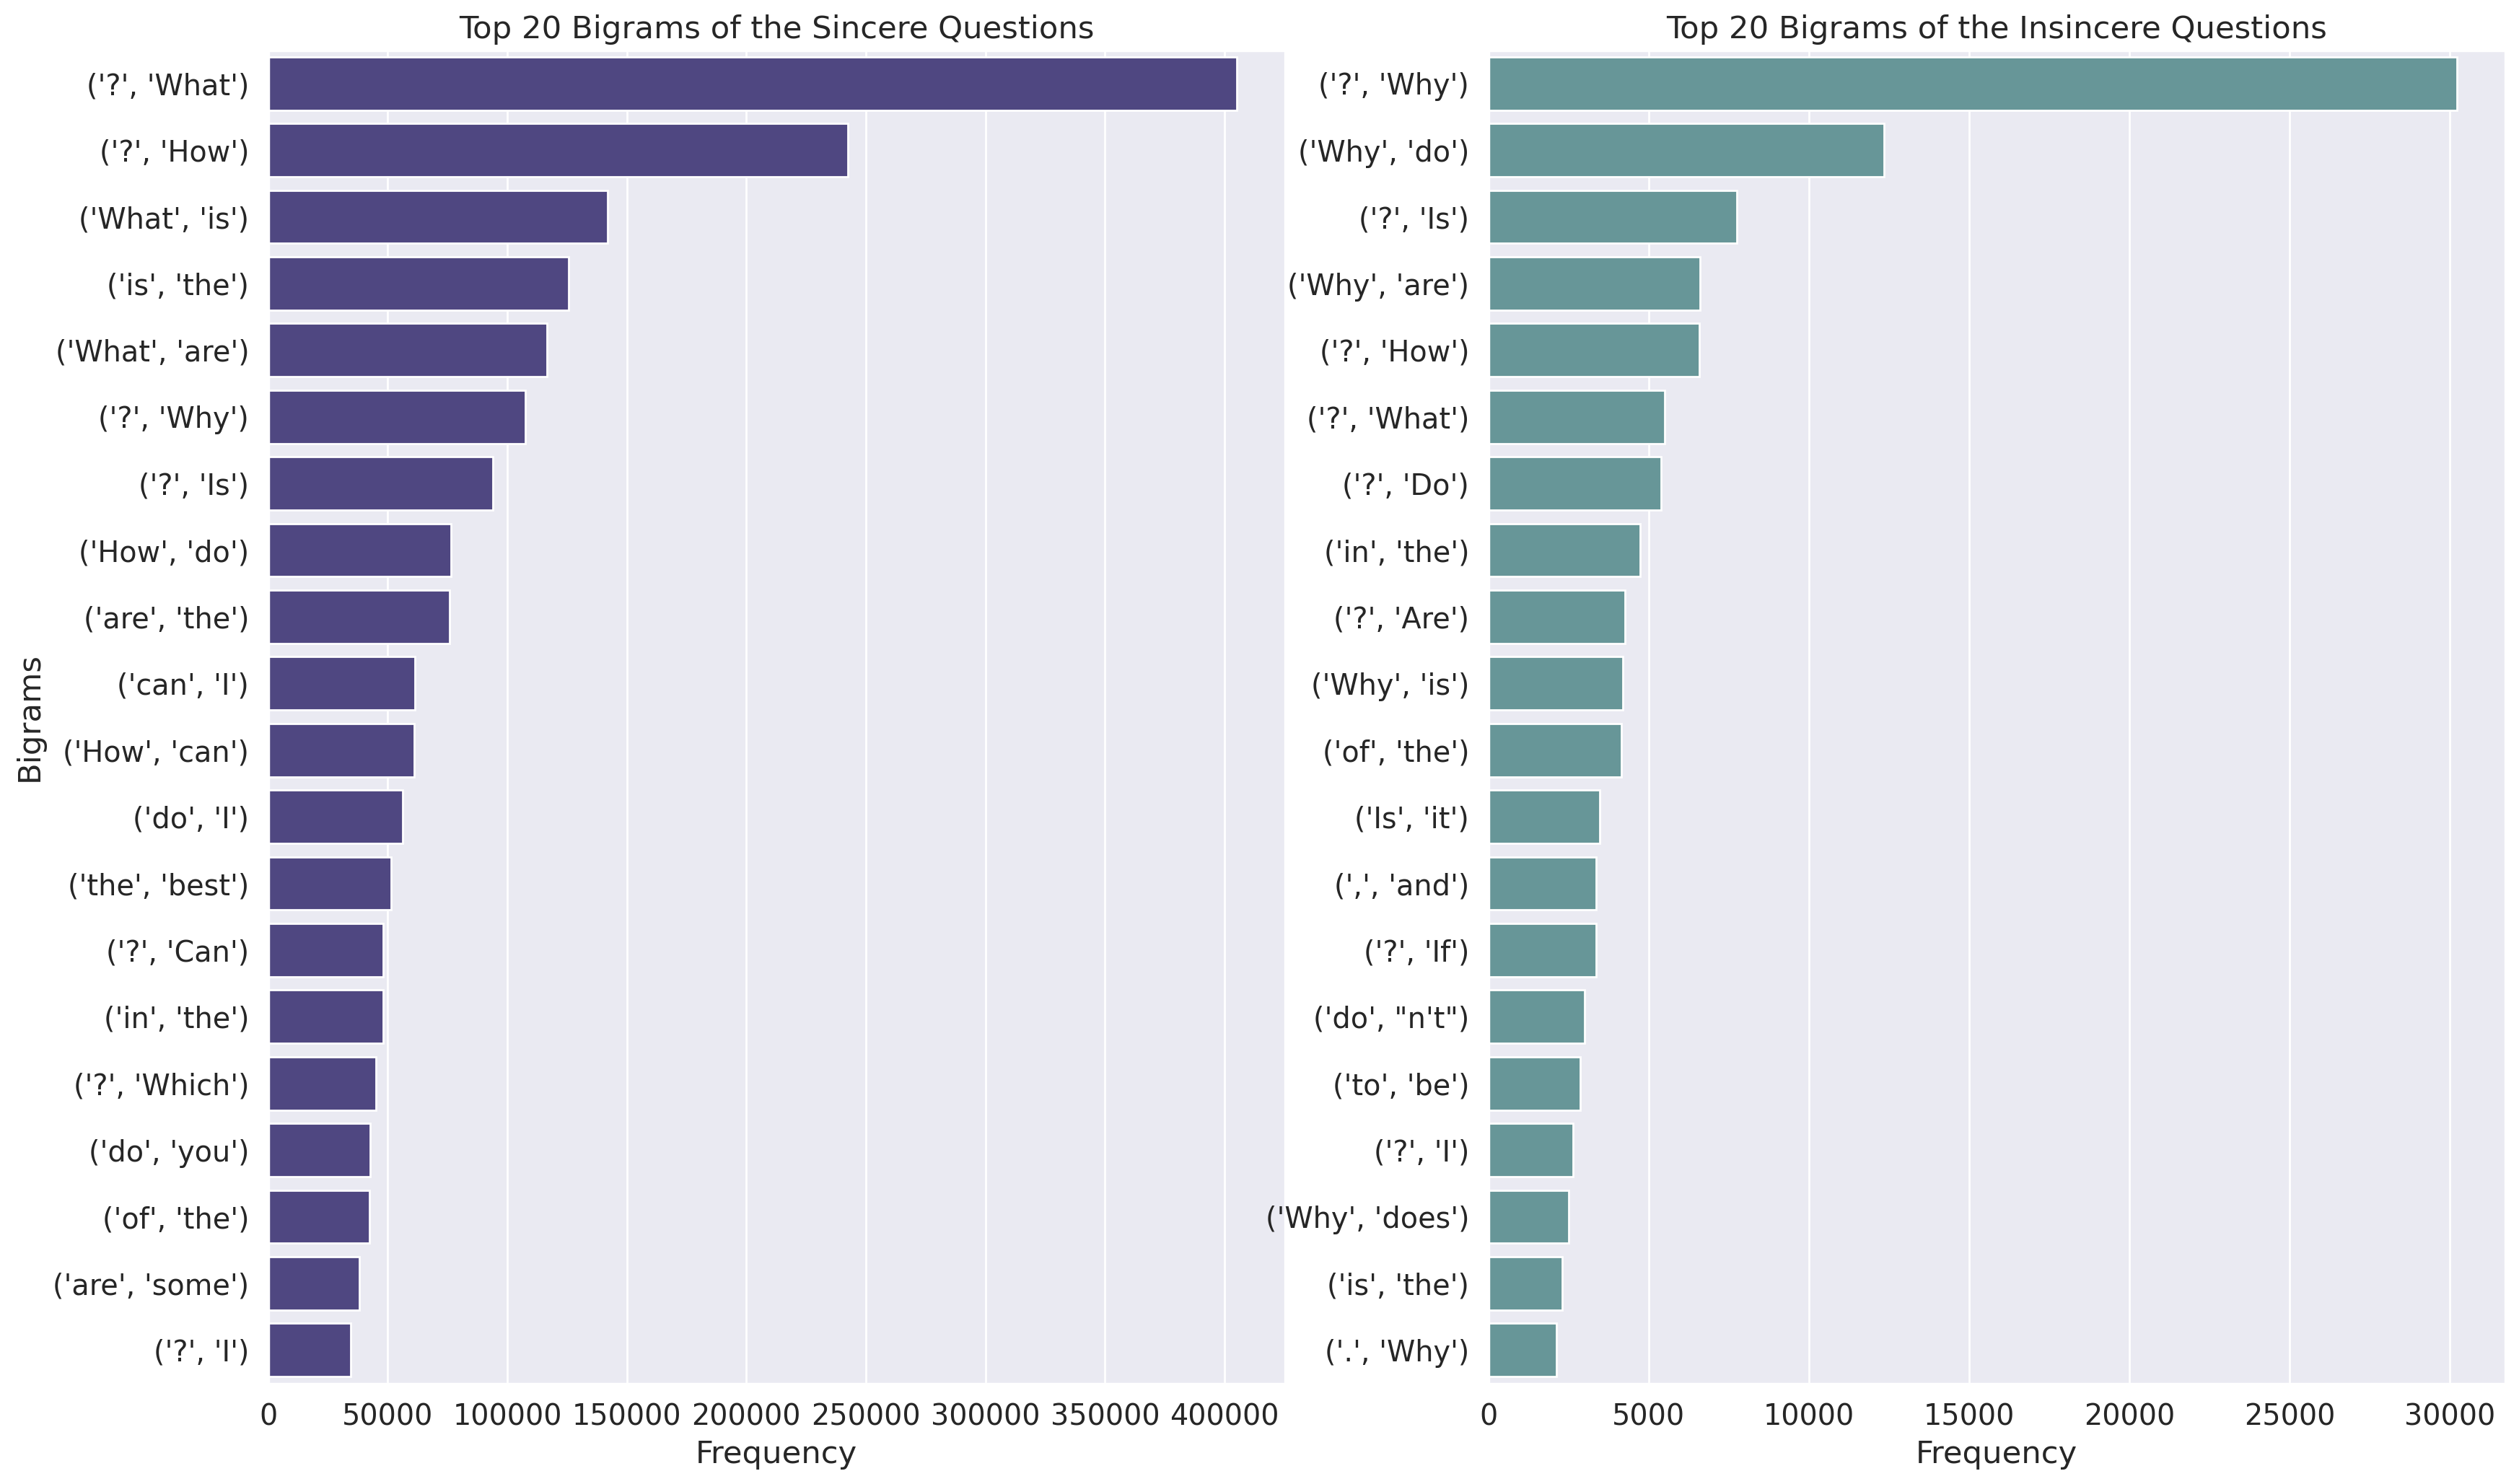

In [9]:
# Bigrams
bigram_insincere = ngrams(tokenized_insincere, 2)
bigram_sincere = ngrams(tokenized_sincere, 2)

# Making the Frequency chart for the Bigrams
frequency_insincere = Counter(bigram_insincere) 
frequency_sincere = Counter(bigram_sincere)

df_freq_insincere = pd.DataFrame(frequency_insincere.most_common(20))
df_freq_sincere = pd.DataFrame(frequency_sincere.most_common(20))

# Barplot that shows the top 20 Bigrams
plt.rcParams['figure.figsize'] = [20, 12]
fig, ax = plt.subplots(1, 2)
sns.set(font_scale = 1.3, style = 'darkgrid')

sns_sincere = sns.barplot(x = df_freq_sincere[1], y = df_freq_sincere[0], color = 'darkslateblue', ax = ax[0])
sns_insincere = sns.barplot(x = df_freq_insincere[1], y = df_freq_insincere[0], color = 'cadetblue', ax = ax[1])

# Setting axes
sns_sincere.set(title = "Top 20 Bigrams of the Sincere Questions", ylabel = "Bigrams", xlabel = "Frequency")
sns_insincere.set(title = "Top 20 Bigrams of the Insincere Questions", xlabel = "Frequency", ylabel = "");

### Distribution of Polarity and Subjectivity of the questions

In [10]:
# Calculating Polarity of the questions 
def sentiment_polarity(questions):
    # Sentiment polarity of the questions
    pol = []
    for i in questions:
        analysis = TextBlob(i)
        pol.append(analysis.sentiment.polarity)
    return pol

# Subjectivity of the questions
def sentiment_subjectivity(questions):
    # Sentiment subjectivity of the questions
    sub = []
    for i in questions:
        analysis = TextBlob(i)
        sub.append(analysis.sentiment.subjectivity)
    return sub

# Appeding the polarity and subjectivity of the text in the dataframe
df['polarity'] = sentiment_polarity(df['question_text'])
df['subjectivity'] = sentiment_subjectivity(df['question_text'])

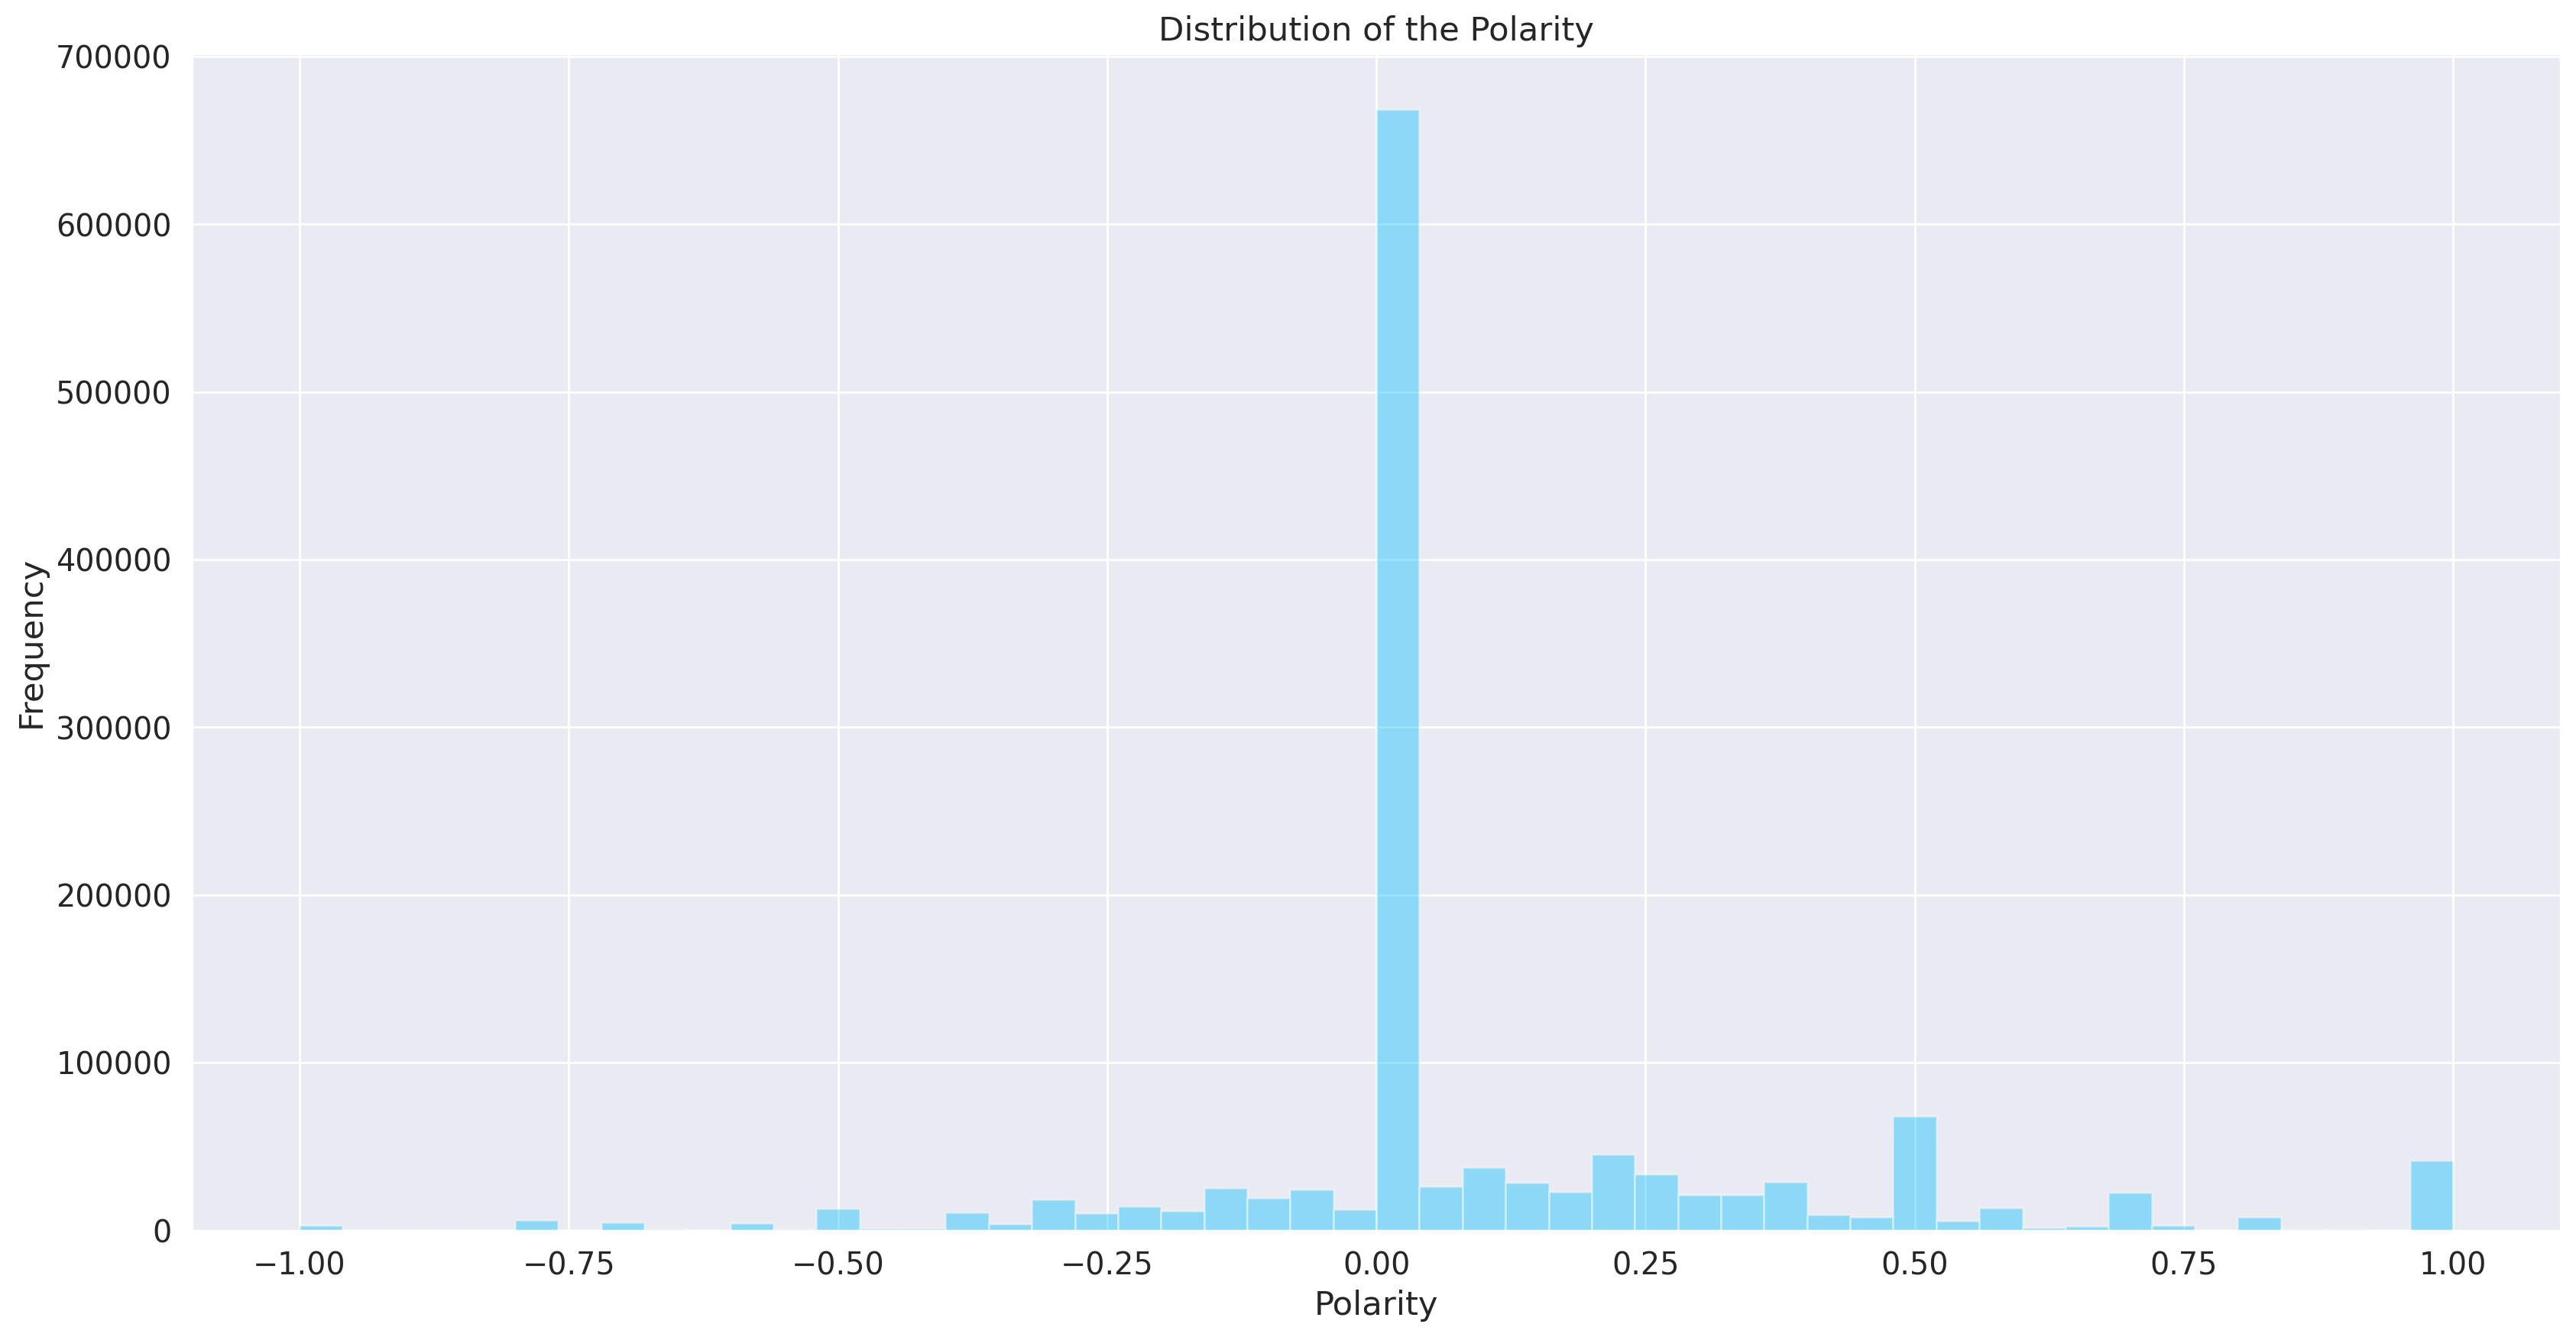

In [11]:
# Distribution plot
plt.rcParams['figure.figsize'] = [20, 10]
# sns.set(style = 'white', font_scale = 1.5)

dist_ = sns.distplot(df['polarity'], kde = False, color = 'deepskyblue')
# Setting the axes
dist_.set(title = 'Distribution of the Polarity', xlabel = 'Polarity', ylabel = 'Frequency');

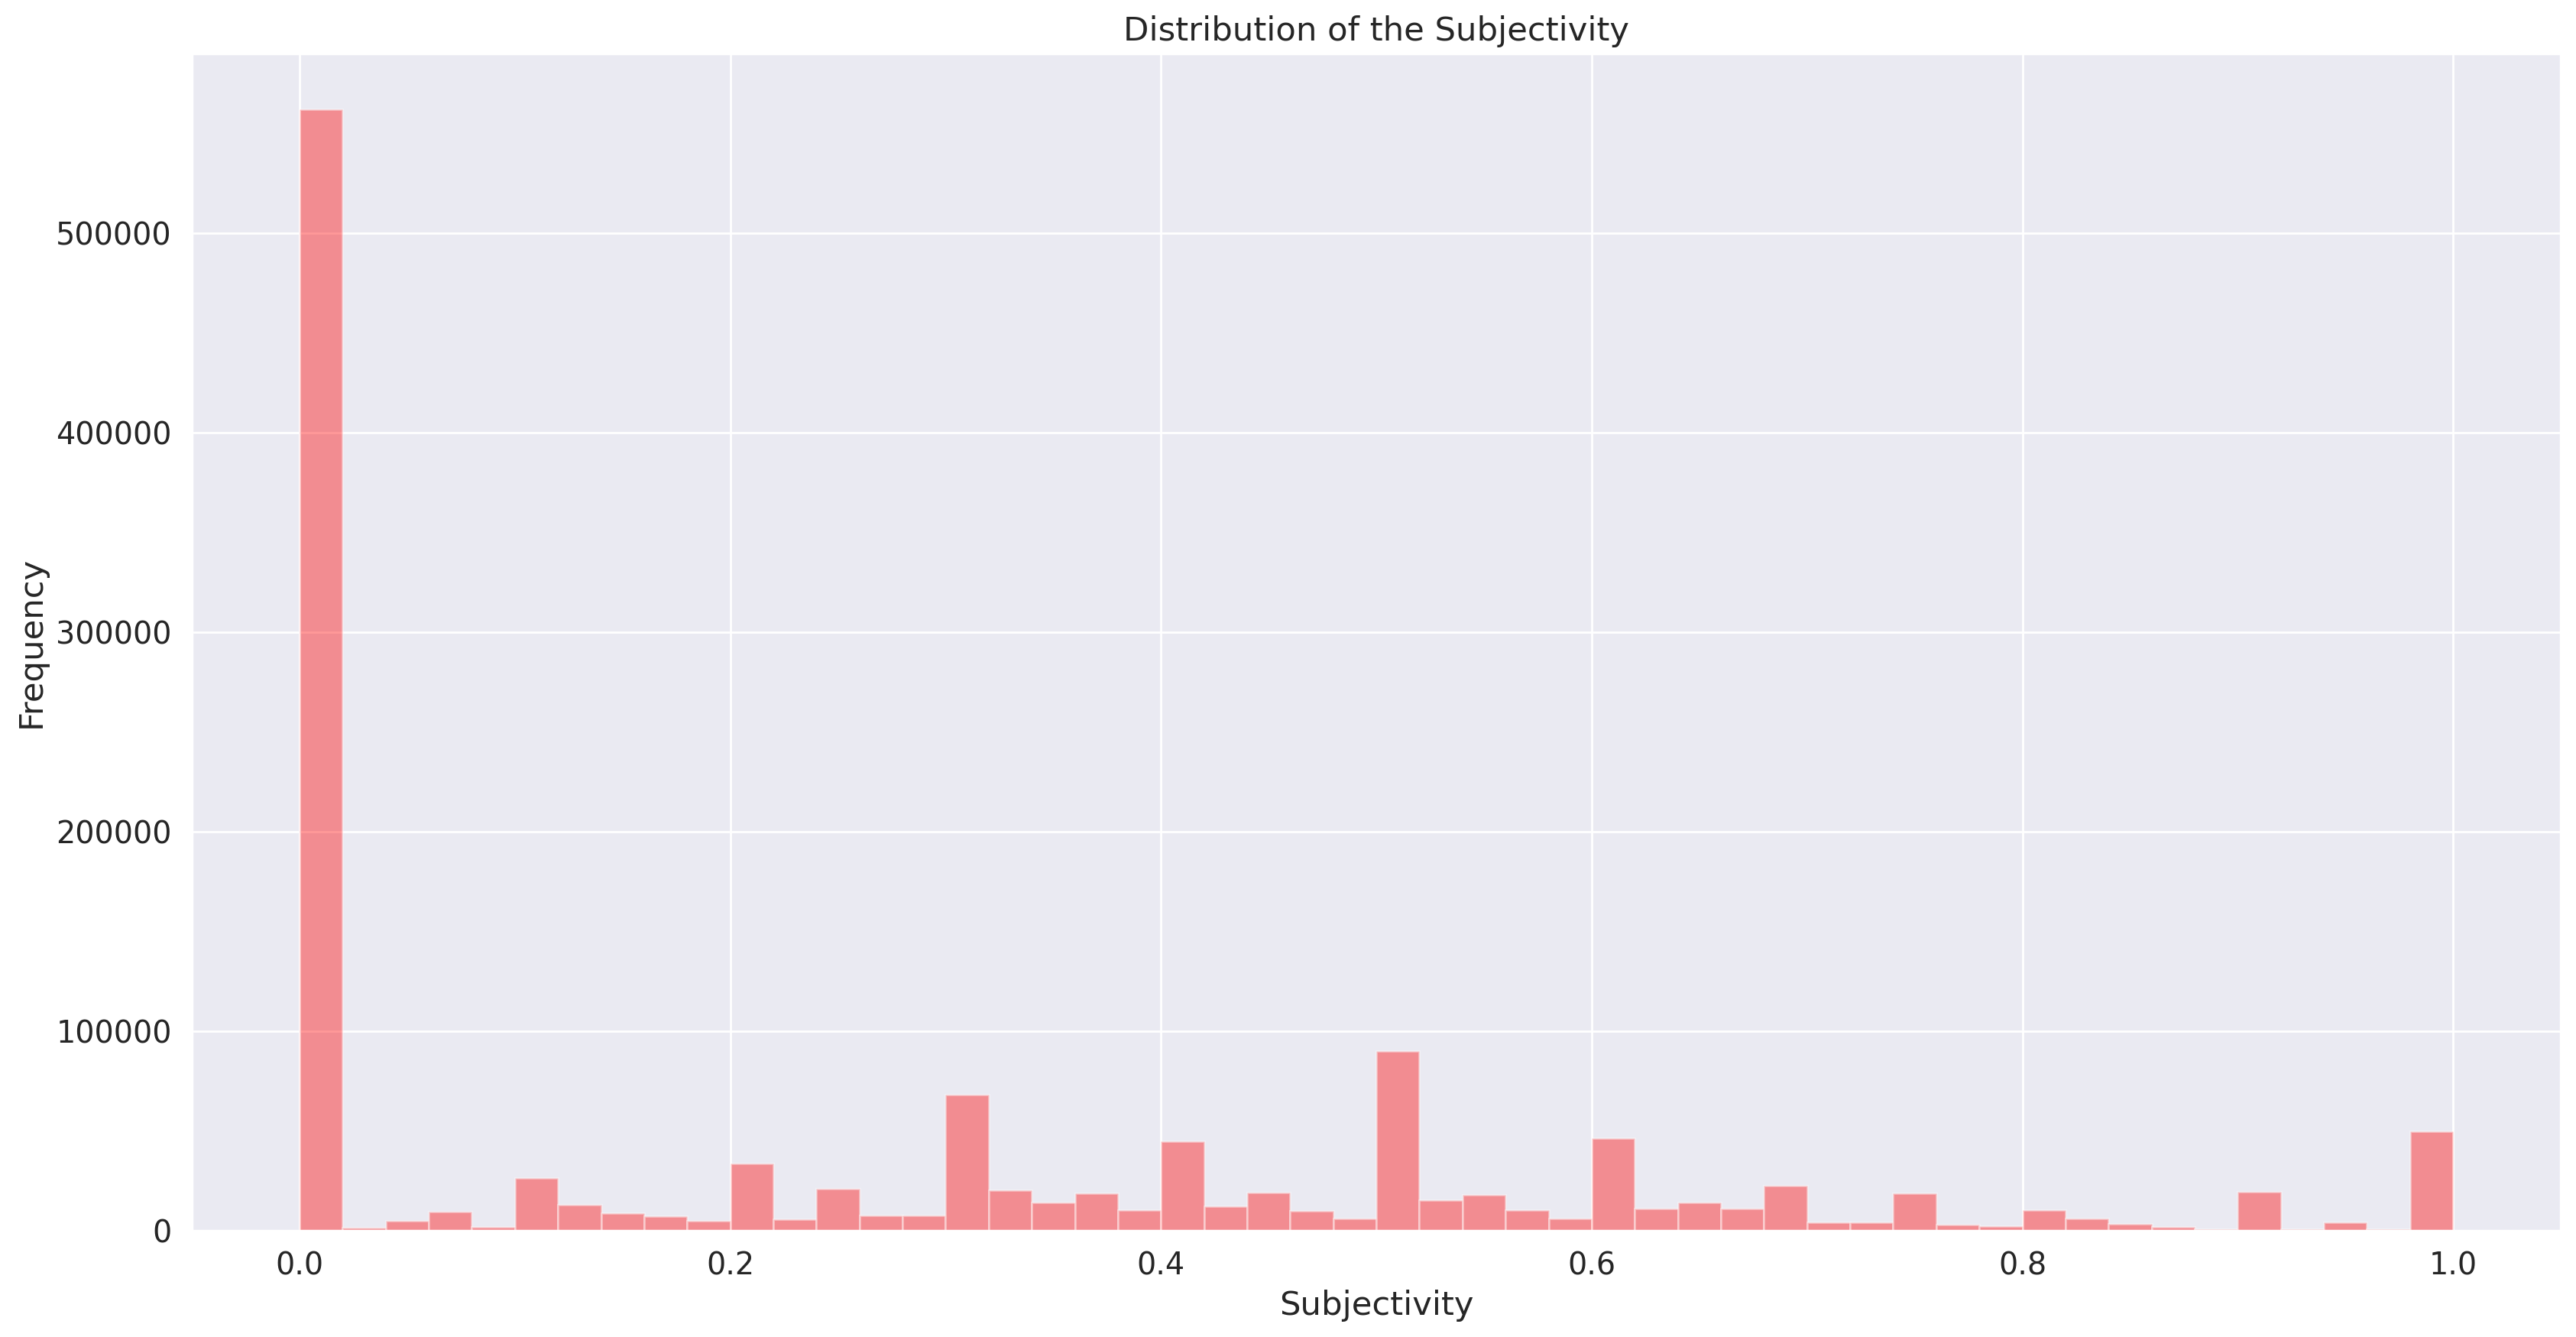

In [12]:
# Distribution plot
plt.rcParams['figure.figsize'] = [20, 10]
dist_ = sns.distplot(df['subjectivity'], kde = False, color = 'red')
# Setting the axes
dist_.set(title = 'Distribution of the Subjectivity', xlabel = 'Subjectivity', ylabel = 'Frequency');

## Preprocessing

In [13]:
# Changing the target values for BERT
df['target'] = df['target'].map({'Insincere' : 1, 'Sincere' : 0})

# Dropping polarity and subjectivity as it's not going to be used in training BERT
df.drop(columns = ['polarity', 'subjectivity'], inplace = True)

In [14]:
# Contraction Dictionary for the expansion
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "doesn’t": "does not", "don't": "do not", "don’t": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
    "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
    "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not","might've": "might have",
    "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not","sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have",
    "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
    "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y’all": "you all", "y'all'd": "you all would",
    "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "ain’t": "am not", "aren’t": "are not",
    "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have",
    "he’s": "he is", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
    "i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have",
    "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
    "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
    "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
    "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have",
    "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "she’s": "she is",
    "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "so’s": "so is",
    "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would", "there’d’ve": "there would have",
    "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will", "they’ll’ve": "they will have",
    "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have",
    "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
    "what’ll’ve": "what will have", "what’re": "what are", "what’s": "what is", "what’ve": "what have", "when’s": "when is",
    "when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will",
    "who’ll’ve": "who will have", "who’s": "who is", "who’ve": "who have","why’s": "why is", "why’ve": "why have", "will’ve": "will have",
    "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have",
    "y’all": "you all", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are",
    "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
    "you’re": "you are", "you’re": "you are", "you’ve": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [15]:
# Function to clean the html from the Questions
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict = contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the questions
def main_preprocessing(question):
    global question_sent
    
    # Removing the HTML
    question = question.apply(lambda x: cleanhtml(x))
    
    # Removing the email ids
    question = question.apply(lambda x: re.sub('\S+@\S+','', x))
    
    # Removing The URLS
    question = question.apply(lambda x: re.sub("((http\://|https\://|ftp\://)|(www.))+(([a-zA-Z0-9\.-]+\.[a-zA-Z]{2,4})|([0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}))(/[a-zA-Z0-9%:/-_\?\.'~]*)?",'', x))
    
    # Mapping the contractions
    question = question.apply(lambda x: expand_contractions(x))
    
    # Stripping the possessives
    question = question.apply(lambda x: x.replace("'s", ''))
    question = question.apply(lambda x: x.replace('’s', ''))
    question = question.apply(lambda x: x.replace("\'s", ''))
    question = question.apply(lambda x: x.replace("\’s", ''))
    
    # Removing the Trailing and leading whitespace and double spaces
    question = question.apply(lambda x: re.sub(' +', ' ',x))
    
    # Removing punctuations from the question
    question = question.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might lead to a white space
    question = question.apply(lambda x: re.sub(' +', ' ',x))
    
    return question

In [16]:
# Doing some preprocessing
df['processed_text'] = main_preprocessing(df['question_text'])
df['processed_text'] = df['processed_text'].astype('str')

df = resample(df, random_state = RANDOM_SEED) # Resampling

In [17]:
df.head(20)

,qid,question_text,target,processed_text
121958,17df11bf9b1888d64add,I feel something missing in my relationship. I...,0,I feel something missing in my relationship I ...
671155,837181f0407fd112a05c,"What do Socrates, Thomas Kuhn and Karl Popper ...",0,What do Socrates Thomas Kuhn and Karl Popper h...
131932,19d09fe4bbabf16eb347,What song played in the movie of the gifted wh...,0,What song played in the movie of the gifted wh...
259178,32b9bf37edd829ffe658,What are the biggest myths about Adolf Hitler?,0,What are the biggest myths about Adolf Hitler
110268,1595cbbad9c20d3d791a,How can the ViewSonic PA503S 3600 lumens SVGA ...,0,How can the ViewSonic PA503S 3600 lumens SVGA ...
732180,8f652b1d9c7ce951b75a,How does the Indian youth think about the seni...,0,How does the Indian youth think about the seni...
1103462,d8432db83bb1474dd0e1,Will the free flow of information fracture soc...,0,Will the free flow of information fracture soc...
137337,1ae2fc81766361bf12c0,Are blacks justified in using violence against...,1,Are blacks justified in using violence against...
999890,c3f2ab0ed5cb6e85385b,Is there any way that I could download videos ...,0,Is there any way that I could download videos ...
1136074,dea920d0a07d8956a004,Can a constructed be inherited?,0,Can a constructed be inherited


## BERT Modelling

#### BERT Configurations

In [18]:
# Bert Parameters
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 1 # Can be increased but the training time will also increase significantly

#### Tokenizing

In [19]:
# Bert Tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Bert Tokenizer with example
sample_txt = 'Corona Sucks so bad, my final year is kinda ruined, man!!'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',  
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Sentence: Corona Sucks so bad, my final year is kinda ruined, man!!
   Tokens: ['Co', '##rona', 'Su', '##cks', 'so', 'bad', ',', 'my', 'final', 'year', 'is', 'kinda', 'ruined', ',', 'man', '!', '!']
Token IDs: [3291, 15789, 15463, 8770, 1177, 2213, 117, 1139, 1509, 1214, 1110, 21884, 9832, 117, 1299, 106, 106]


dict_keys(['input_ids', 'attention_mask'])

In [20]:
# Using the Bert tokenizer for encoding the questions
token_lens = []

for txt in tqdm(df.processed_text):
    encoding = tokenizer.encode_plus(
        txt,
        max_length=512,
        truncation=True,
        padding='max_length',  # Padding to max length
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )
    token_lens.append(encoding['input_ids'].shape[1])  # Append the token length

100%|██████████| 1306122/1306122 [11:32<00:00, 1885.71it/s]


In [21]:
# Preparing the dataset with input ids and attention_masks
class GPquestionDataset(Dataset):
    
    def __init__(self, questions, targets, tokenizer, max_len):
        self.questions = questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, item):
        question = str(self.questions[item])
        target = self.targets[item]

        # Encoding the question text using the tokenizer
        encoding = self.tokenizer.encode_plus(
            question,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', 
            return_attention_mask=True,
            return_tensors='pt',  # Return PyTorch tensors
            truncation=True  
        )

        return {
            'question_text': question,
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the batch dimension (1,)
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Same here
            'targets': torch.tensor(target, dtype=torch.long)
        }

#### Splitting the Dataset and creating separate dataloaders

In [22]:
# Splitting the dataset for training, validation and testing
df_train, df_test = train_test_split(
  df,
  test_size = 0.4,
  random_state = RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size = 0.6,
  random_state = RANDOM_SEED
)
print ("The shape of the training dataset : ", df_train.shape)
print ("The shape of the validation dataset : ", df_val.shape)
print ("The shape of the testing dataset : ", df_test.shape)

The shape of the training dataset :  (783673, 4)
The shape of the validation dataset :  (208979, 4)
The shape of the testing dataset :  (313470, 4)


In [23]:
# Creating the data loader for training, validation, and testing using the PyTorch DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPquestionDataset(
        questions = df.processed_text.to_numpy(),
        targets = df.target.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 0
    )

# Creating data loaders for train, validation, and test sets
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Accessing one batch from the training data loader
data = next(iter(train_data_loader))

# Checking the keys in the batch
print(data.keys())

# Printing the number of batches in each DataLoader
print(len(train_data_loader))  # Number of batches in the training set
print(len(val_data_loader))    # Number of batches in the validation set
print(len(test_data_loader))   # Number of batches in the test set

dict_keys(['question_text', 'input_ids', 'attention_mask', 'targets'])
48980
13062
19592


In [24]:
# Shape of the torch
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


#### Downloading Base BERT Model

In [25]:
# Using the Bert Model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Forward pass
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

# Extracting the last hidden state correctly
last_hidden_state = output.last_hidden_state
pooled_output = output.pooler_output

print(last_hidden_state.shape)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

torch.Size([1, 512, 768])


#### Setting the Model Architecture

In [26]:
# Model with BERT layer and Dropout
class QuestionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(QuestionClassifier, self).__init__()
        # Loading pre-trained BERT model
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        # Dropout layer with 30% probability of dropout
        self.drop = nn.Dropout(p = 0.3)
        # Final classification layer (Linear) with output size based on number of classes
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT model
        outputs = self.bert(input_ids = input_ids, attention_mask = attention_mask)
        # Pooled output
        pooled_output = outputs[1]
        # Apply dropout for regularization
        output = self.drop(pooled_output)
        # Final output layer (Linear)
        return self.out(output)

# Initialize model with 2 classes (for binary classification)
model = QuestionClassifier(n_classes=2)
model = model.to(device)  # Move the model to GPU in this case otherwise CPU

In [27]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

outputs = model(input_ids = input_ids, attention_mask = attention_mask)

torch.Size([16, 160])
torch.Size([16, 160])


In [28]:
optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = 0,
  num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

#### Training and Evaluation Functions

In [29]:
# Training function
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples ): 
    
    # Putting the model in training mode
    model = model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        # Moving data to device (GPU or CPU)
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get predictions
        _, preds = torch.max(outputs, dim=1)
        
        # Calculate loss
        loss = loss_fn(outputs, targets)
        
        # Track correct predictions
        correct_predictions += torch.sum(preds == targets).float()
        
        # Append loss for averaging later
        losses.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        
        # Scheduler step (for learning rate adjustment)
        scheduler.step()
        
        # Zero gradients to prevent accumulation from previous steps
        optimizer.zero_grad()
        
    # Return the average accuracy and loss for the epoch
    accuracy = correct_predictions.double() / n_examples
    avg_loss = np.mean(losses)
    return accuracy, avg_loss

In [30]:
# Evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    # Putting the model in evaluation mode
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():  # Disable gradient computation
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Get predictions
            _, preds = torch.max(outputs, dim=1)
            
            # Calculate loss
            loss = loss_fn(outputs, targets)
            
            # Track correct predictions
            correct_predictions += torch.sum(preds == targets).float()
            
            # Append loss for averaging later
            losses.append(loss.item())
    
    # Return accuracy and average loss
    accuracy = correct_predictions.double() / n_examples
    avg_loss = np.mean(losses)
    return accuracy, avg_loss


#### Training and Evaluating the BERT Model

In [31]:
# The training loop
start_time = time.time() # To track the training time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 70)
    
    # Training phase
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    
    # Validation phase
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val loss {val_loss:.4f} accuracy {val_acc:.4f}')
    
    # Log history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # Checking if the model's validation accuracy is the best we've seen
    if val_acc > best_accuracy:
        print(f'Saving model with val_acc {val_acc:.4f}')
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

end_time = time.time()
execution_time = end_time - start_time

print(f"Total execution time: {execution_time:.2f} seconds")

Epoch 1/1
----------------------------------------------------------------------
Train loss 0.1390 accuracy 0.9542
Val loss 0.1237 accuracy 0.9590
Saving model with val_acc 0.9590
Total execution time: 13783.74 seconds


In [32]:
# Making sure the model is in the right device for evaluation
model = model.to(device) 

# Evaluating the model
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

print (test_acc)

tensor(0.9591, device='cuda:0', dtype=torch.float64)


In [33]:
# Predictions function
def get_predictions(model, data_loader):
    model = model.eval()  # Set model to evaluation mode
    question_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():  # Disable gradients for inference
        for d in data_loader:
            texts = d["question_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Gettting predictions (indices of max logits)
            _, preds = torch.max(outputs, dim=1)
            
            # Collecting data
            question_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(torch.softmax(outputs, dim=1).cpu())  # Converting logits to probabilities
            real_values.extend(targets)
    
    # Converting lists to tensors and move to CPU
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return question_texts, predictions, prediction_probs, real_values

y_question_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

# Checking the results
print("Sample predictions:", y_pred[:5])
print("Sample probabilities:", y_pred_probs[:5])

Sample predictions: tensor([0, 0, 0, 0, 0])
Sample probabilities: tensor([[9.9868e-01, 1.3162e-03],
        [9.9902e-01, 9.8329e-04],
        [9.9898e-01, 1.0177e-03],
        [9.9899e-01, 1.0138e-03],
        [9.9702e-01, 2.9819e-03]])


In [34]:
# First 10 predictions and corresponding texts
i = 0
for t, pred, prob in zip(y_question_texts, y_pred, y_pred_probs):
    print(f"Text: {t}")
    print(f"Prediction: {pred}   Probabilities: {prob.numpy()}")
    print('-' * 50)  # Divider for readability
    i += 1
    if i == 10:
        break

Text: What is the site Allthefallen ninja Is it safe
Prediction: 0   Probabilities: [0.99868387 0.00131616]
--------------------------------------------------
Text: What influenced your desire to work in the field of peace and conflict resolution
Prediction: 0   Probabilities: [9.9901664e-01 9.8329375e-04]
--------------------------------------------------
Text: A number is multiplied by half of itself and then 32 it is added to the product if the final result is 130 then find the original number
Prediction: 0   Probabilities: [0.99898225 0.00101769]
--------------------------------------------------
Text: What do I need to do if I travel to India
Prediction: 0   Probabilities: [0.9989862  0.00101375]
--------------------------------------------------
Text: Do some losers live a good life
Prediction: 0   Probabilities: [0.9970181  0.00298195]
--------------------------------------------------
Text: Can Pakistan be perceived as an abandoned child of akhand Bharat who grows up to become 

In [35]:
# Classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    294093
           1       0.72      0.56      0.63     19377

    accuracy                           0.96    313470
   macro avg       0.84      0.77      0.80    313470
weighted avg       0.96      0.96      0.96    313470



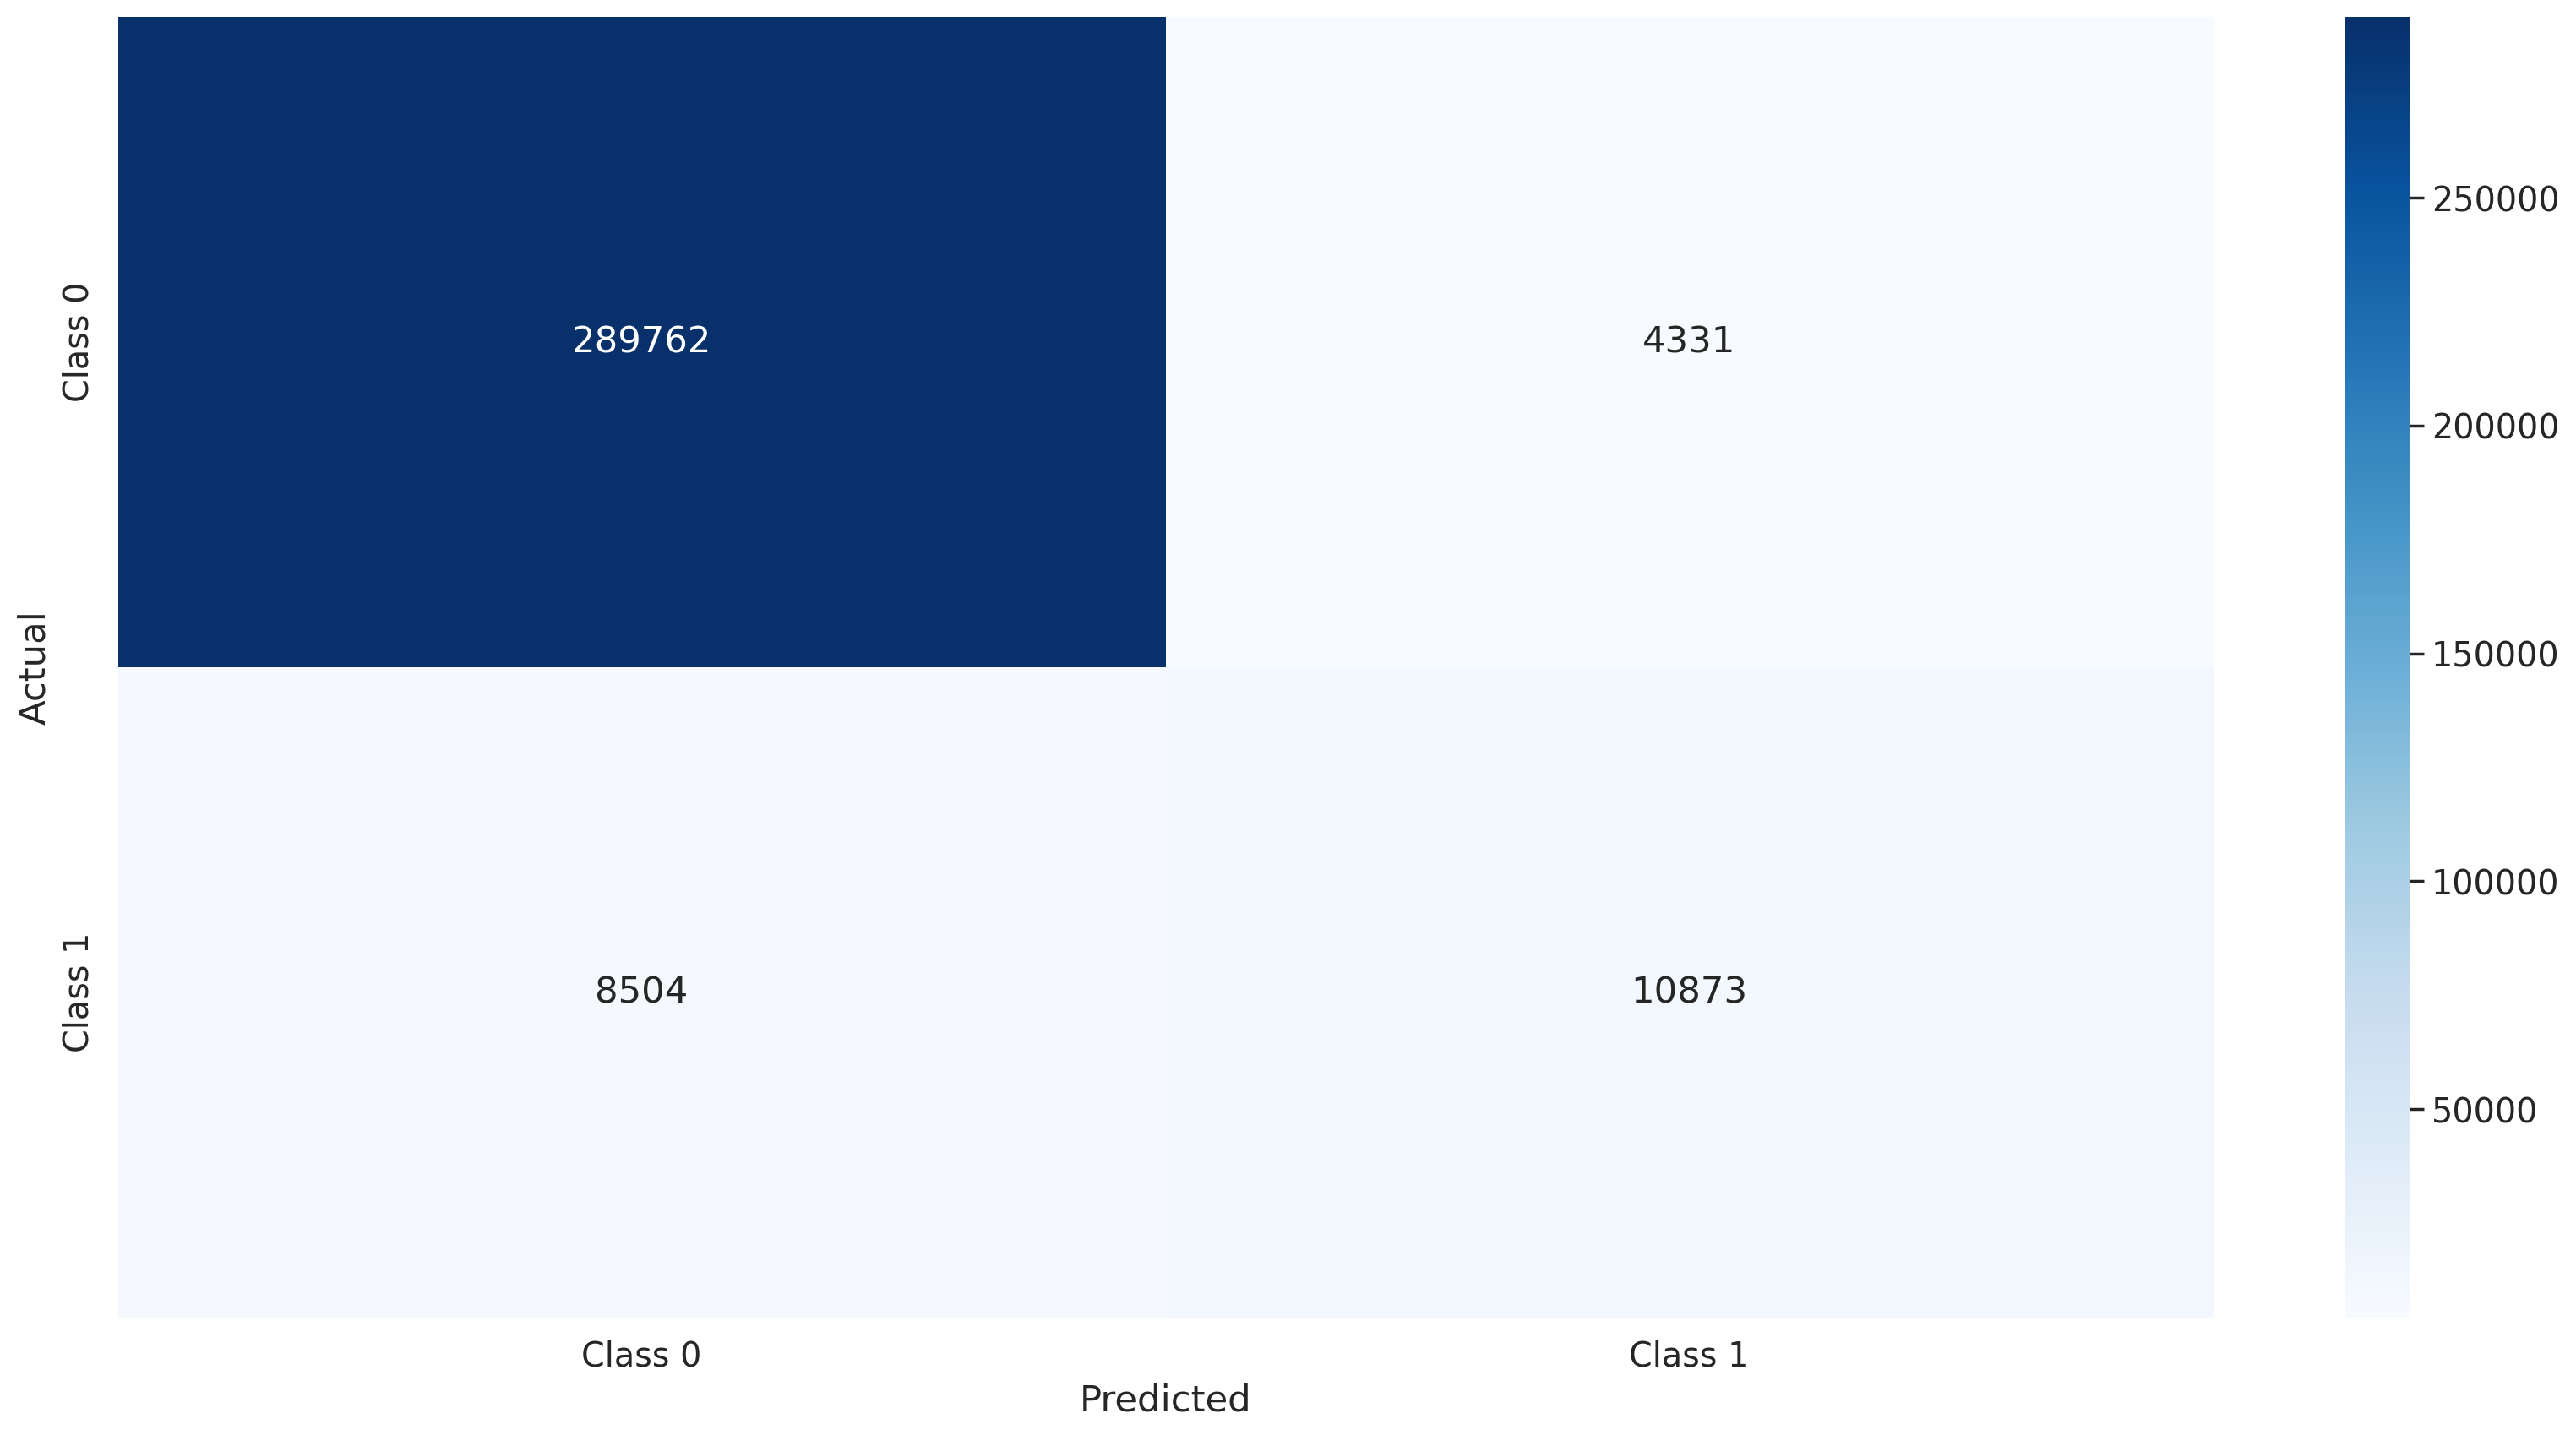

In [36]:
# Confusion matrix
conf = confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

Accuracy won't be useful since the dataset is highly skewed as shown in the EDA, so using f1_score for evaluation

In [37]:
# f1_score
print (f1_score(y_test, y_pred))

0.6288424279228478
